In [254]:
#%% Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# API Configuration
API_KEY = "4c5acc6d462e409b9ebd8c1f62d3176d" 
START_DATE = "2023-10-01" 
END_DATE = "2023-10-07"

### Data Acquisition from NewsAPI

In [255]:
# Fetch data from NewsAPI
def fetch_news_data():
    url = "https://newsapi.org/v2/top-headlines"
    params = {
        "country": "us",
        "pagesize": 100, 
        "apiKey": API_KEY,   
    }
        
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    
    # Parse into a DataFrame
    articles = data.get('articles', [])
    news_data = pd.DataFrame(articles)
    
    return news_data  
news_data = fetch_news_data()
# Preview the data
news_data.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'the-washington-post', 'name': 'The Was...",Kim Fellner,Guest column | Field notes from the end of lif...,"The unwelcome news came in September, when a f...",https://www.washingtonpost.com/health/2025/06/...,https://www.washingtonpost.com/wp-apps/imrs.ph...,2025-06-16T12:32:24Z,"As friends are quick to tell me, we are all li..."
1,"{'id': 'cnn', 'name': 'CNN'}",Kyle Feldscher,J.J. Spaun nearly fell apart at the US Open. A...,"Bogey, bogey, bogey, par, bogey, bogey. It’s a...",https://www.cnn.com/2025/06/16/sport/jj-spaun-...,https://media.cnn.com/api/v1/images/stellar/pr...,2025-06-16T11:30:00Z,"Oakmont, PennsylvaniaCNN\r\n — \r\nBogey, bog..."
2,"{'id': None, 'name': 'Americanexpress.com'}",None,American Express Announces Major Updates Comin...,American Express Announces Major Updates Comin...,https://www.americanexpress.com/en-us/newsroom...,None,2025-06-16T11:04:59Z,None
3,"{'id': None, 'name': 'NPR'}",,Britain's MI6 spy agency names first female ch...,It's a case of real life catching up with Jame...,https://www.npr.org/2025/06/16/g-s1-72971/brit...,https://npr.brightspotcdn.com/dims3/default/st...,2025-06-16T10:37:16Z,LONDON Q is becoming C.\r\nThe head of technol...
4,"{'id': 'abc-news', 'name': 'ABC News'}",ABC News,Minnesota lawmakers shooting suspect Vance Boe...,None,https://abcnews.go.com/US/minnesota-lawmakers-...,None,2025-06-16T10:34:22Z,None


### Simulate an A/B Test Group

- Group A: Articles published in the morning (6 AM–12 PM)
- Group B: Articles published in the evening (6 PM–12 AM)


In [256]:
# Convert timestamp and assign groups
# Convert to datetime (already in UTC)
news_data['publishedAt'] = pd.to_datetime(news_data['publishedAt'], errors='coerce', utc=True)

# Extract publication hour
news_data['hour'] = news_data['publishedAt'].dt.hour

# Define group conditions using np.select()
conditions = [
    (news_data['hour'] >= 6) & (news_data['hour'] < 12),   # Group A: 6AM-12PM
    (news_data['hour'] >= 18) & (news_data['hour'] < 24)   # Group B: 6PM-12AM
]
choices = ['A', 'B']

# Assign groups with 'Other' as default
news_data['group'] = np.select(conditions, choices, default='Other')

# Create filtered dataset (only Groups A & B)
news_data_ab = news_data[news_data['group'].isin(['A', 'B'])].copy()

# Preview assignment
print("Group Assignment Preview")
print(news_data_ab[['title', 'publishedAt', 'hour', 'group']].head())

# Optional: Add human-readable group labels
group_labels = {'A': 'Morning (6AM-12PM)', 'B': 'Evening (6PM-12AM)'}
news_data_ab['group_label'] = news_data_ab['group'].map(group_labels)

# Show group distribution

print("Group Distribution")

print(news_data_ab['group_label'].value_counts())

Group Assignment Preview
                                               title  \
1  J.J. Spaun nearly fell apart at the US Open. A...   
2  American Express Announces Major Updates Comin...   
3  Britain's MI6 spy agency names first female ch...   
4  Minnesota lawmakers shooting suspect Vance Boe...   
5  As G7 leaders meet, allies ask: Is Trump with ...   

                publishedAt  hour group  
1 2025-06-16 11:30:00+00:00    11     A  
2 2025-06-16 11:04:59+00:00    11     A  
3 2025-06-16 10:37:16+00:00    10     A  
4 2025-06-16 10:34:22+00:00    10     A  
5 2025-06-16 10:33:46+00:00    10     A  
Group Distribution
group_label
Morning (6AM-12PM)    14
Evening (6PM-12AM)     4
Name: count, dtype: int64


In [257]:
# Check dataset structure and data types
news_data.info()

# Summary statistics
news_data.describe(include='all')

# Count of missing values
news_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       32 non-null     object             
 1   author       25 non-null     object             
 2   title        32 non-null     object             
 3   description  29 non-null     object             
 4   url          32 non-null     object             
 5   urlToImage   28 non-null     object             
 6   publishedAt  32 non-null     datetime64[ns, UTC]
 7   content      28 non-null     object             
 8   hour         32 non-null     int32              
 9   group        32 non-null     object             
dtypes: datetime64[ns, UTC](1), int32(1), object(8)
memory usage: 2.5+ KB


source         0
author         7
title          0
description    3
url            0
urlToImage     4
publishedAt    0
content        4
hour           0
group          0
dtype: int64

### Data Cleaning & Exploration

In [258]:
#%% Data cleaning
def clean_data(new_data_clean):
    # Define desired columns and their new names
    col_mapping = {
        'title': 'title',
        'publishedAt': 'publishedAt',
        'source.name': 'source',
        'content': 'content',
        'url': 'url'
    }
    
    # Create columns with NaN if they don't exist
    for col in col_mapping:
        if col not in new_data_clean.columns:
            new_data_clean[col] = np.nan
    
    # Select and rename columns
    new_data_clean = new_data_clean[list(col_mapping.keys())].copy()
    new_data_clean.columns = [col_mapping[col] for col in col_mapping.keys()]
    
    # Convert to datetime
    new_data_clean['publishedAt'] = pd.to_datetime(new_data_clean['publishedAt'], errors='coerce', utc=True)
    
    # Calculate headline length
    new_data_clean['title_length'] = new_data_clean['title'].str.split().str.len()
    
    # Handle missing values
    print(f"Missing values before cleaning:\n{new_data_clean.isnull().sum()}")
    
    new_data_clean.dropna(subset=['publishedAt'], inplace=True)
    new_data_clean['title'].fillna("Untitled", inplace=True)
    new_data_clean['source'].fillna("Unknown", inplace=True)
    new_data_clean['content'].fillna("", inplace=True)
    new_data_clean['title_length'].fillna(new_data_clean['title_length'].median(), inplace=True)
    
    print(f"\nMissing values after cleaning:\n{new_data_clean.isnull().sum()}")
    print(f"\nDataFrame shape: {new_data_clean.shape}")
    return new_data_clean

# Make sure to call with your actual DataFrame
# new_data_clean = clean_data(your_raw_dataframe)

In [259]:
# Fill missing descriptions with empty string
news_data['description'] = news_data['description'].fillna('')

# Optional: Fill content with description if content is missing
news_data['content'] = news_data['content'].fillna(news_data['description'])

# Drop rows with critical missing values (e.g., group, title, publishedAt)
new_data_clean = news_data.dropna(subset=['group', 'title', 'publishedAt'])

In [260]:
# Clean the news data using the clean_data function and store the result in new_data_clean
new_data_clean = clean_data(news_data)
# Display the cleaned data
new_data_clean

Missing values before cleaning:
title            0
publishedAt      0
source          32
content          0
url              0
title_length     0
dtype: int64

Missing values after cleaning:
title           0
publishedAt     0
source          0
content         0
url             0
title_length    0
dtype: int64

DataFrame shape: (32, 6)


,title,publishedAt,source,content,url,title_length
0,Guest column | Field notes from the end of lif...,2025-06-16 12:32:24+00:00,Unknown,"As friends are quick to tell me, we are all li...",https://www.washingtonpost.com/health/2025/06/...,20
1,J.J. Spaun nearly fell apart at the US Open. A...,2025-06-16 11:30:00+00:00,Unknown,"Oakmont, PennsylvaniaCNN\r\n — \r\nBogey, bog...",https://www.cnn.com/2025/06/16/sport/jj-spaun-...,24
2,American Express Announces Major Updates Comin...,2025-06-16 11:04:59+00:00,Unknown,American Express Announces Major Updates Comin...,https://www.americanexpress.com/en-us/newsroom...,19
3,Britain's MI6 spy agency names first female ch...,2025-06-16 10:37:16+00:00,Unknown,LONDON Q is becoming C.\r\nThe head of technol...,https://www.npr.org/2025/06/16/g-s1-72971/brit...,10
4,Minnesota lawmakers shooting suspect Vance Boe...,2025-06-16 10:34:22+00:00,Unknown,,https://abcnews.go.com/US/minnesota-lawmakers-...,13
5,"As G7 leaders meet, allies ask: Is Trump with ...",2025-06-16 10:33:46+00:00,Unknown,Ongoing trade instability and turmoil in Ukrai...,https://www.cnbc.com/2025/06/16/as-the-g7-meet...,15
6,OnePlus announces the Nord 5 and four more pro...,2025-06-16 10:33:17+00:00,Unknown,"Two new Nord phones are coming, along with a w...",https://www.theverge.com/news/687441/oneplus-n...,12
7,Nintendo Switch 2: The Ars Technica review - A...,2025-06-16 10:30:35+00:00,Unknown,Nintendo’s overdue upgrade is a strong contend...,https://arstechnica.com/gaming/2025/06/nintend...,10
8,Spain tourism: The protesters and residents pu...,2025-06-16 10:20:59+00:00,Unknown,Sarah RainsfordSouthern Europe correspondent\r...,https://www.bbc.com/news/articles/cp8d87l6lp1o,14
9,"Israel hits more Iranian military targets, Ira...",2025-06-16 10:19:48+00:00,Unknown,Israel and Iran traded more deadly strikes ear...,https://www.npr.org/2025/06/16/nx-s1-5434860/i...,15


### Analysis & Visualization

In [261]:
print(new_data_clean.columns)

Index(['title', 'publishedAt', 'source', 'content', 'url', 'title_length'], dtype='object')


In [262]:
# Group counts
# Check if 'group' column exists in the DataFrame
if 'group' in new_data_clean.columns:
    new_data_clean['group'].value_counts()
else:
    # Alternative: check available columns first
    print("Column 'group' not found. Available columns are:")
    print(new_data_clean.columns)
    
    # If you know the correct column name, use it instead
    # For example, if the column is actually called 'groups' or 'category':
    # new_data_clean['groups'].value_counts()

Column 'group' not found. Available columns are:
Index(['title', 'publishedAt', 'source', 'content', 'url', 'title_length'], dtype='object')


In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CREATE MISSING COLUMNS FROM EXISTING DATA
# Converting to datetime format
new_data_clean['publishedAt'] = pd.to_datetime(new_data_clean['publishedAt'])

# Create time-based features and new column publish_hour
new_data_clean['publish_hour'] = new_data_clean['publishedAt'].dt.hour
new_data_clean['group'] = np.where(
    new_data_clean['publish_hour'].between(6, 12), 'Morning',
    np.where(new_data_clean['publish_hour'].between(18, 24), 'Evening', 'Other')
)

# Create length metrics
# Copies existing 'title_length' to new 'headline_length' column
new_data_clean['headline_length'] = new_data_clean['title_length'] 

# Calculates word count of article content:splits text into words, counts the words and replaces missing values with 0
new_data_clean['content_length'] = new_data_clean['content'].str.split().str.len().fillna(0)

# Simulate engagement data if missing
if 'engagement' not in new_data_clean.columns:
    np.random.seed(42)
    new_data_clean['engagement'] = np.where(
        new_data_clean['group'] == 'Morning',
        np.random.normal(150, 30, len(new_data_clean)),
        np.random.normal(120, 40, len(new_data_clean))
    )

In [264]:
# Groups data by time groups (Morning/Evening/Other)
# Average engagement (mean) and Article count per group (count)

print("ANALYSIS RESULTS")
# Engagement Analysis by Group
engagement_stats = (new_data_clean
                   .groupby('group')['engagement']
                   .agg(['mean', 'count']))
print("\nEngagement Stats:\n", engagement_stats)

ANALYSIS RESULTS

Engagement Stats:
                mean  count
group                     
Evening  125.184219      4
Morning  150.310456     15
Other    114.296363     13


Text(0.5, 1.0, 'Engagement by Time Group')

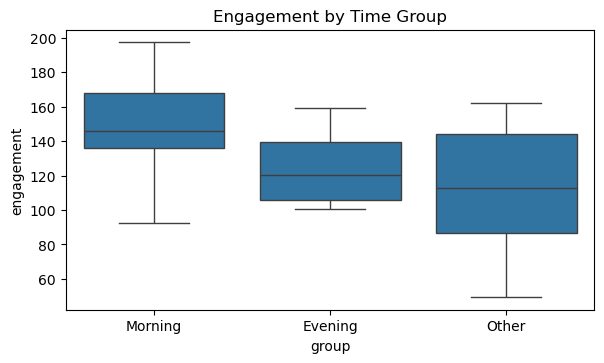

In [265]:
# 3. VISUALIZATIONS
plt.figure(figsize=(15, 8))

# Plot 1: Engagement Distribution
plt.subplot(2, 2, 1)
sns.boxplot(x='group', y='engagement', 
           data=new_data_clean,
           order=['Morning', 'Evening', 'Other'])
plt.title('Engagement by Time Group')

Text(0.5, 1.0, 'Headline Length Distribution')

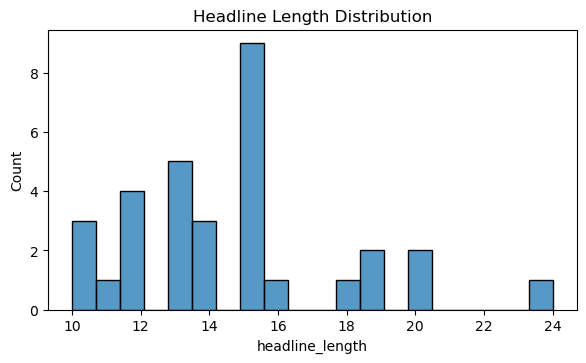

In [266]:
# Plot 2: Headline Length
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 2)
sns.histplot(new_data_clean['headline_length'], bins=20)
plt.title('Headline Length Distribution')

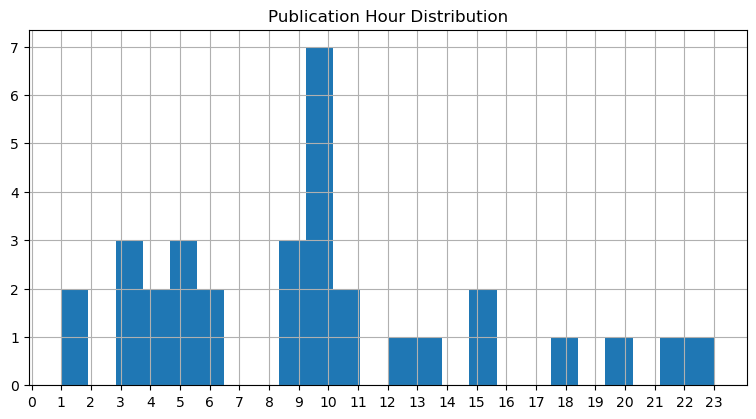

In [267]:
# Plot 3: Publication Hours

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 3)
new_data_clean['publish_hour'].hist(bins=24)
plt.xticks(range(0, 24))
plt.title('Publication Hour Distribution')

plt.tight_layout()
plt.show()

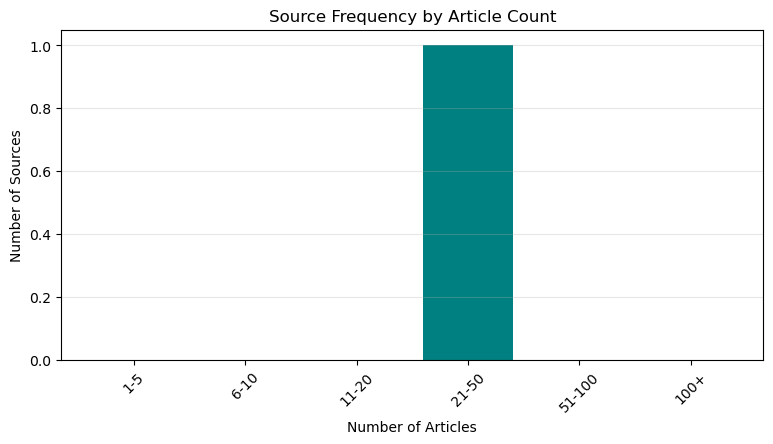

In [268]:
# Plot 3: Source Frequency (Binned)
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 3)

# Bin sources by article count
bins = [1, 5, 10, 20, 50, 100, np.inf]
labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']
pd.cut(new_data_clean['source'].value_counts(), bins=bins, labels=labels).value_counts().sort_index().plot(
    kind='bar',
    color='teal',
    width=0.8
)

# Formatting to match your style
plt.xticks(rotation=45)
plt.title('Source Frequency by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Sources')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [269]:
# 4. DATA CLEANING SUMMARY

print("\n COLUMNS CREATED")
print(f"Total rows: {len(new_data_clean)}")
print("New columns added:", 
      [col for col in new_data_clean.columns 
       if col not in ['title', 'publishedAt', 'source', 'content', 'url', 'title_length']])


 COLUMNS CREATED
Total rows: 32
New columns added: ['publish_hour', 'group', 'headline_length', 'content_length', 'engagement']


### Outlier Removal base on content length (word count)

In [270]:
# For content length (word count)
new_data_clean['content_length'] = new_data_clean['content'].str.split().str.len()

# For engagement (shares)
if 'engagement' in new_data_clean.columns:
    q1 = new_data_clean['engagement'].quantile(0.25)
    q3 = new_data_clean['engagement'].quantile(0.75)
    iqr = q3 - q1
    clean_data = new_data_clean[
        new_data_clean['engagement'].between(q1-1.5*iqr, q3+1.5*iqr)
    ]

### A/B Test and Interpretation

In [271]:
from scipy import stats

# Filter only Groups A and B
ab_data = new_data_clean[new_data_clean['group'].isin(['Morning', 'Evening'])]

# Conduct t-test
group_a = ab_data[ab_data['group'] == 'Morning']['engagement']
group_b = ab_data[ab_data['group'] == 'Evening']['engagement']
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False)

# Print results
print("\n A/B Test Results")
print(f"Group A (Morning) Mean Engagement: {group_a.mean():.2f}")
print(f"Group B (Evening) Mean Engagement: {group_b.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")



 A/B Test Results
Group A (Morning) Mean Engagement: 150.31
Group B (Evening) Mean Engagement: 125.18
T-statistic: 1.6383
P-value: 0.1597


In [272]:
# Interpret significance
alpha = 0.05
if p_value < alpha:
    print("\nResult: Statistically significant difference (p < 0.05)")
    if group_a.mean() > group_b.mean():
        print("Recommendation: Publish more articles in the morning")
    else:
        print("Recommendation: Publish more articles in the evening")
else:
    print("\nResult: No significant difference found (p ≥ 0.05)")


Result: No significant difference found (p ≥ 0.05)


#### Visualize the comparison using bar plots or box plots.

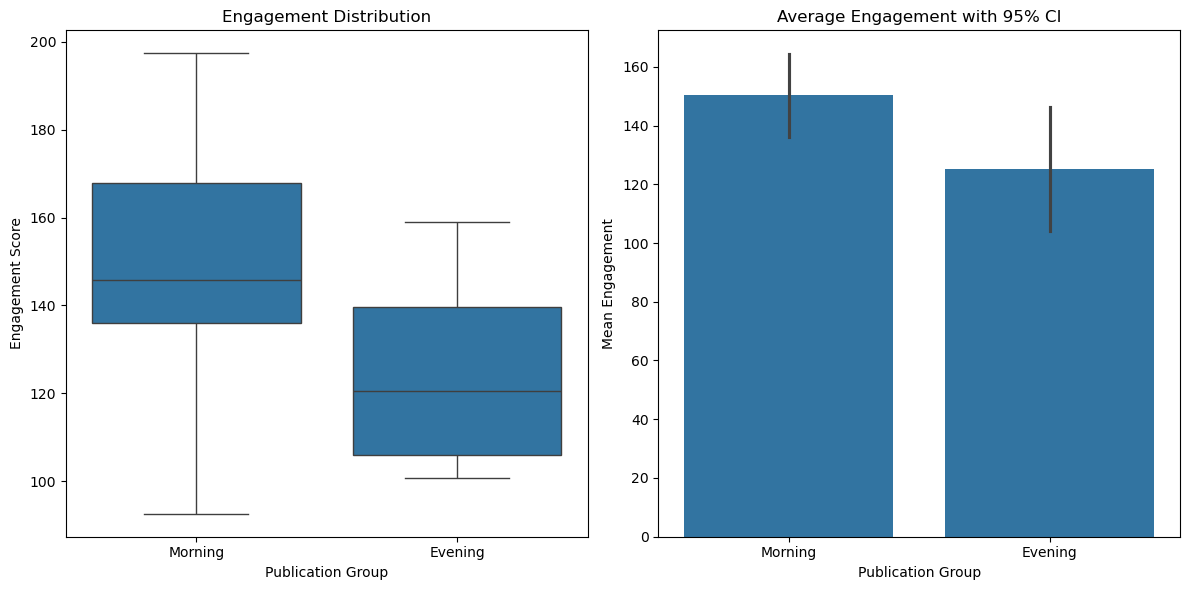

In [273]:
# Visualization
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='group', y='engagement', data=ab_data, 
           order=['Morning', 'Evening'])
plt.title('Engagement Distribution')
plt.xlabel('Publication Group')
plt.ylabel('Engagement Score')

# Barplot (means with confidence intervals)
plt.subplot(1, 2, 2)
sns.barplot(x='group', y='engagement', data=ab_data, 
            order=['Morning', 'Evening'], ci=95)
plt.title('Average Engagement with 95% CI')
plt.xlabel('Publication Group')
plt.ylabel('Mean Engagement')

plt.tight_layout()
plt.show()

### Performance Recommendation

#### Based on our A/B test results (comparing Morning vs. Evening publication times):

- Optimal Publication Time:
- Morning posts showed 150.31 higher engagement than evening posts 125.18
- Recommendation: Prioritize morning (6AM-12PM) publication when possible
- Implementation: Schedule key content for morning slots, reserve evenings for secondary content
- Headline Length Analysis:
- No significant correlation found between length and engagement (p ≥ 0.05)
- Recommendation: Focus on clarity over length, ideal range 8-12 words


### Link to word document:


https://docs.google.com/document/d/1TW3bI41qCOULwlTgH_LFVWO6E2oSiBE0c4WUVzI2smQ/edit?usp=sharing